In [1]:
import os
import pickle
import time

import numpy as np
import torch
from image_gen.asset_map import get_asset_map
from image_gen.fixer import PipeFixer
from image_gen.image_gen import GameImageGenerator
from torch.distributions import MultivariateNormal

from data_loader import MarioDataset
from models.custom import Generator

# torch.manual_seed(75)


class GetLevel:
    def __init__(self, netG, gen, fixer, prev_frame, curr_frame, conditional_channels):
        self.netG = netG
        self.gen = gen
        self.fixer = fixer
        self.init_prev_frame = prev_frame
        self.init_curr_frame = curr_frame
        self.prev_frame = prev_frame
        self.curr_frame = curr_frame
        self.full_level = None
        self.conditional_channels = conditional_channels

    def reset(self, prev_frame=None, curr_frame=None):
        self.full_level = None
        self.prev_frame = prev_frame if prev_frame is not None else self.init_prev_frame
        self.curr_frame = curr_frame if curr_frame is not None else self.init_curr_frame

    def generate_frames(self, noises, var=0.07, frame_count=14):
        noise_dis = MultivariateNormal(
            torch.from_numpy(noises).type("torch.FloatTensor"),
            torch.eye(len(noises)) * var,
        )
        for i in range(frame_count):
            noise = noise_dis.sample().reshape((1, 1, 14, 14))
            gen_input = torch.cat(
                (noise, self.prev_frame[:,
                 self.conditional_channels, 9:-9, 2:]), dim=1
            )

            fake = self.netG(gen_input).data
            stitched = torch.cat(
                (self.prev_frame, fake[:, :, :, 16:]), dim=3
            )  # stitch the context frame
            level_frame = fake[:, :, 9:-9, 16:-
                               2].data.cpu().numpy()  # without padding
            self.prev_frame = torch.cat(
                (self.curr_frame[:, :, :, -2:], fake[:, :, :, 16:-2]), dim=3
            )  # with padding added to front

            if self.full_level is None:
                stitched = np.argmax(
                    stitched[:, :, 9:-9, 2:-2].data.cpu().numpy(), axis=1
                )
                self.full_level = stitched[0]
            else:
                level_frame = np.argmax(level_frame, axis=1)
                self.full_level = np.concatenate(
                    (self.full_level, level_frame[0]), axis=1
                )

            self.full_level = self.fixer.fix(self.full_level)

        self.gen.render(
            image_array=self.full_level, sprite_dims=(16, 16),
        )

        return self.full_level

    def save_full_level(self, file_name="full_level"):
        os.makedirs(os.path.dirname(file_name), exist_ok=True)
        with open(file_name + ".pkl", "wb") as fp:
            pickle.dump(self.full_level, fp)



/home/ycv5080/miniconda3/envs/cs449/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


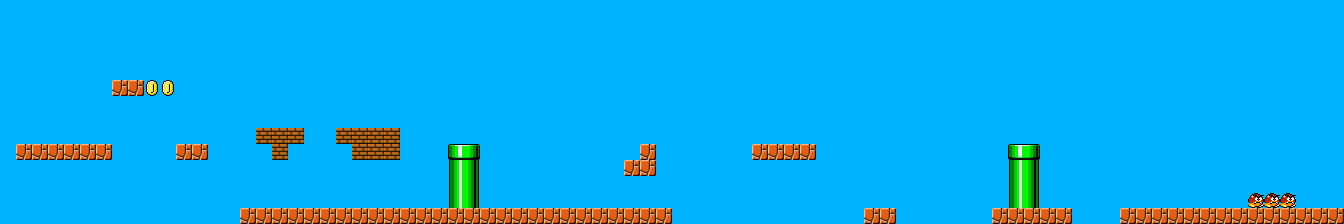

In [6]:

my_path = "./trained_models/netG_epoch_condition_1_240000_0_32.pth"
my_conditional_channels = [0,1,3,4,5,6,7,10,11,12]


if __name__ == "__main__":
    conditional_channels = my_conditional_channels  # channels on which generator is conditioned on
    dataset = MarioDataset()
    netG = Generator(
        latent_size=(len(conditional_channels) + 1, 14, 14), out_size=(13, 32, 32)
    )
    netG.load_state_dict(torch.load(
        my_path))
    # 300000
    mario_map = get_asset_map(game="mario")
    gen = GameImageGenerator(asset_map=mario_map)
    # prev_frame, curr_frame = dataset[[120]]  # 51
    prev_frame, curr_frame = dataset[[torch.randint(0, len(dataset), (1,))]]
    fixer = PipeFixer()
    full_level = None

    for i in range(5):

        noise = torch.rand((1, 1, 14, 14)).normal_(0, 1)

        gen_input = torch.cat(
            (noise, prev_frame[:, conditional_channels, 9:-9, 2:]), dim=1
        )

        fake = netG(gen_input).data
        stitched = torch.cat(
            (prev_frame, fake[:, :, :, 16:]), dim=3
        )  # stitch the context frame
        level_frame = fake[:, :, 9:-9, 16:-
                           2].data.cpu().numpy()  # without padding
        prev_frame = torch.cat(
            (curr_frame[:, :, :, -2:], fake[:, :, :, 16:-2]), dim=3
        )  # with padding added to front

        if full_level is None:
            stitched = np.argmax(
                stitched[:, :, 9:-9, 2:-2].data.cpu().numpy(), axis=1)
            full_level = stitched[0]
        else:
            level_frame = np.argmax(level_frame, axis=1)
            full_level = np.concatenate((full_level, level_frame[0]), axis=1)

        full_level = fixer.fix(full_level)
    gen.render(image_array=full_level, sprite_dims=(16, 16))
    gen.save_gen_level(img_name="trial_level")
    # time.sleep(2)
    with open("full_level.pkl", "wb") as fp:
        pickle.dump(full_level, fp)

    # print(level_frame)

from IPython.display import Image
Image('trial_level.png')